# Zigzag

## functions

In [27]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

global ny, N, a1
ny = 10 # unit cell number in y direction
N = 2*ny
a1 = np.sqrt(3)/(2) # a = 1, a1 = a*sqrt(3)/2
    
def NB(T, E):
    # Bose distribution
    if abs(E/T) > 500:
        return 0
    else: return 1/(np.exp(E/T) - 1) 

def eigenv(H):
    '''  setup eigenvalues and eigenvectors
    parameters:
        H: np.ndarray
            Hamiltonian matrix
    returns:
        E: list
            eigenvalues
        U: np.ndarray
            eigenvectors
            U[i, m]: m: energy, i: sites
        U_dag: np.ndarray
            conjugate transpose of U
    '''
    
    E, U = np.linalg.eig(H)
    # E -= np.min(E)+1e-10 # shift to positive
    # print(f'Eigenvalue: {E}')
    U_dag = np.conjugate(U).T
    
    return E, U, U_dag
    # return E

def hamiltonian_0(j, J, d, h, k):
    ''' H in A, B basis
    '''
    
    ni = lambda i: i % N
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    phase = np.exp(1j * k * a1)
    Pnn = j*(phase + 1/phase)
    Pnnn = J*(phase + 1/phase)
    Pd = 1j*d*(phase - 1/phase)
    
    mat = np.eye(N, dtype=np.complex64) * (3*j+6*J+h + J*(phase**2+1/(phase**2)))
    
    for i in A:
        
        mat[ni(i), ni(i+1)] += Pnn
        mat[ni(i), ni(i-1)] += j 
        
        mat[ni(i), ni(i+2)] += (Pnnn + Pd)
        mat[ni(i), ni(i-2)] += (Pnnn + Pd)
        mat[ni(i+2), ni(i)] += (Pnnn + Pd)
        mat[ni(i-2), ni(i)] += (Pnnn + Pd)
        mat[ni(i), ni(i)] -= 1j*d*(phase**2 - 1/(phase**2))
        
    for i in B: 
        
        mat[ni(i), ni(i+1)] += j
        mat[ni(i), ni(i-1)] += Pnn
        
        mat[ni(i), ni(i+2)] += (Pnnn - Pd)
        mat[ni(i), ni(i-2)] += (Pnnn - Pd)
        mat[ni(i+2), ni(i)] += (Pnnn - Pd)
        mat[ni(i-2), ni(i)] += (Pnnn - Pd)
        mat[ni(i), ni(i)] += 1j*d*(phase**2 - 1/(phase**2))
        
    # boundary condition
    
    i = 0
    mat[ni(i), ni(i-1)] = 0
    mat[ni(i), ni(i-2)] = 0
    
    i = 1
    mat[ni(i), ni(i-2)] = 0
    
    i = N-2
    mat[ni(i), ni(i+2)] = 0
    
    i = N-1
    mat[ni(i), ni(i+1)] = 0
    mat[ni(i), ni(i+2)] = 0

    return mat/2

def hamiltonian_mft(iteration, T, jn, J, d, h, kx, txtout=None):
    ''' H in u, d basis
    '''
    
    K = kx*a1
    
    H_0 = hamiltonian_0(jn, J, d, h, kx)
    E, U, U_dag = eigenv(H_0) # 1st order eigenvalues and eigenvectors
    
    Ei = np.sort(E)
    if txtout is not None:
        with open(txtout, 'w') as f:
            for i in range(N):
                f.write(f'E{i},')
            f.write('\n')
            for i in range(N):
                f.write(f'{np.real(Ei[i])},')
            f.write('\n')
    
    H = np.zeros((N, N), dtype=np.complex64)
    H += U_dag @ H_0 @ U # 1st order H in u, d basis
    
    A = []
    B = []
    for i in range(ny):
        A.append(i*2)
        B.append(i*2 + 1)
        
    for iter in range(iteration):
        
        # V = lambda m,n,i,j: U_dag[m, (i%N)] * U[(j%N), n]
        def V(m, n, i, j):
            if i < 0 or i >= N or j < 0 or j >= N:
                return 0 # OBC
            else: return U_dag[m, i] * U[j, n]
        
        N_b = 0
        for i in range(N):
            N_b += NB(T, E[i]) / N
        
        for m in range(N):
            for n in range(N):
                
                n_b = N_b - NB(T, E[n]) 
                
                for a in A:
                    # NN terms
                    H[m, n] += (jn*n_b/4) * (V(m,n,a,a-1) + V(m,n,a-1,a) - 4*V(m,n,a,a))
                    H[m, n] += (jn*n_b/2) * (V(m,n,a,a+1) + V(m,n,a+1,a) - 4*V(m,n,a,a)) * np.cos(K)
                    H[m, n] += (jn*N_b/2) * (V(m,n,a,a-1) + V(m,n,a-1,a))
                    H[m, n] += (jn*N_b) * (V(m,n,a,a+1) + V(m,n,a+1,a)) * np.cos(K)
                    
                    # NNN terms
                    H[m, n] += (J*n_b/2) * (V(m,n,a,a-2)+V(m,n,a-2,a)+V(m,n,a,a+2)+V(m,n,a+2,a) - 8*V(m,n,a,a)) * np.cos(K)
                    H[m, n] += (J*N_b) * (V(m,n,a,a-2)+V(m,n,a-2,a)+V(m,n,a,a+2)+V(m,n,a+2,a)) * np.cos(K)
                    
                    # DMI terms
                    H[m, n] += (d*n_b/2) * (V(m,n,a,a-2)-V(m,n,a-2,a)+V(m,n,a,a+2)-V(m,n,a+2,a)) * np.sin(K)
                    H[m, n] += (d*N_b) * (V(m,n,a,a-2)-V(m,n,a-2,a)+V(m,n,a,a+2)-V(m,n,a+2,a)) * np.sin(K)
                    
                for b in B:
                    # NN terms
                    H[m, n] += (jn*n_b/4) * (V(m,n,b,b+1) + V(m,n,b+1,b) - 4*V(m,n,b,b))
                    H[m, n] += (jn*n_b/2) * (V(m,n,b,b-1) + V(m,n,b-1,b) - 4*V(m,n,b,b)) * np.cos(K)
                    H[m, n] += (jn*N_b/2) * (V(m,n,b,b+1) + V(m,n,b+1,b))
                    H[m, n] += (jn*N_b) * (V(m,n,b,b-1) + V(m,n,b-1,b)) * np.cos(K)
                    
                    # NNN terms
                    H[m, n] += (J*n_b/2) * (V(m,n,b,b-2)+V(m,n,b-2,b)+V(m,n,b,b+2)+V(m,n,b+2,b) - 8*V(m,n,b,b)) * np.cos(K)
                    H[m, n] += (J*N_b) * (V(m,n,b,b-2)+V(m,n,b-2,b)+V(m,n,b,b+2)+V(m,n,b+2,b)) * np.cos(K)
                    
                    # DMI terms
                    H[m, n] += -(d*n_b/2) * (V(m,n,b,b-2)-V(m,n,b-2,b)+V(m,n,b,b+2)-V(m,n,b+2,b)) * np.sin(K)
                    H[m, n] += -(d*N_b) * (V(m,n,b,b-2)-V(m,n,b-2,b)+V(m,n,b,b+2)-V(m,n,b+2,b)) * np.sin(K)
                    
        E, U, U_dag = eigenv(H)
        
        # Ei = np.append(Ei, np.sort(E), axis=0)
        Ei = np.sort(E)
        if txtout is not None:
            with open(txtout, 'a') as f:
                for i in range(N):
                    f.write(f'{np.real(Ei[i])},')
                f.write('\n')
    
        print(f'Iteration {iter} finished.')
        
    return E

## 1st order

In [23]:
j = 1
J = 0.
D = 0.1
h = 0.0
T = 0.1

K = np.pi/a1
spec = np.linspace(0, K, 201)
Erp = []
# bc = ['A', 'B'] # boundary condition
for k in spec:
    E = 0
    H = hamiltonian_0(j, J, D, h, k)
    E, _, _ = eigenv(H)
    Erp.append(np.real(E))
Er = np.array(Erp)
bands = np.array([spec] * len(E))/K

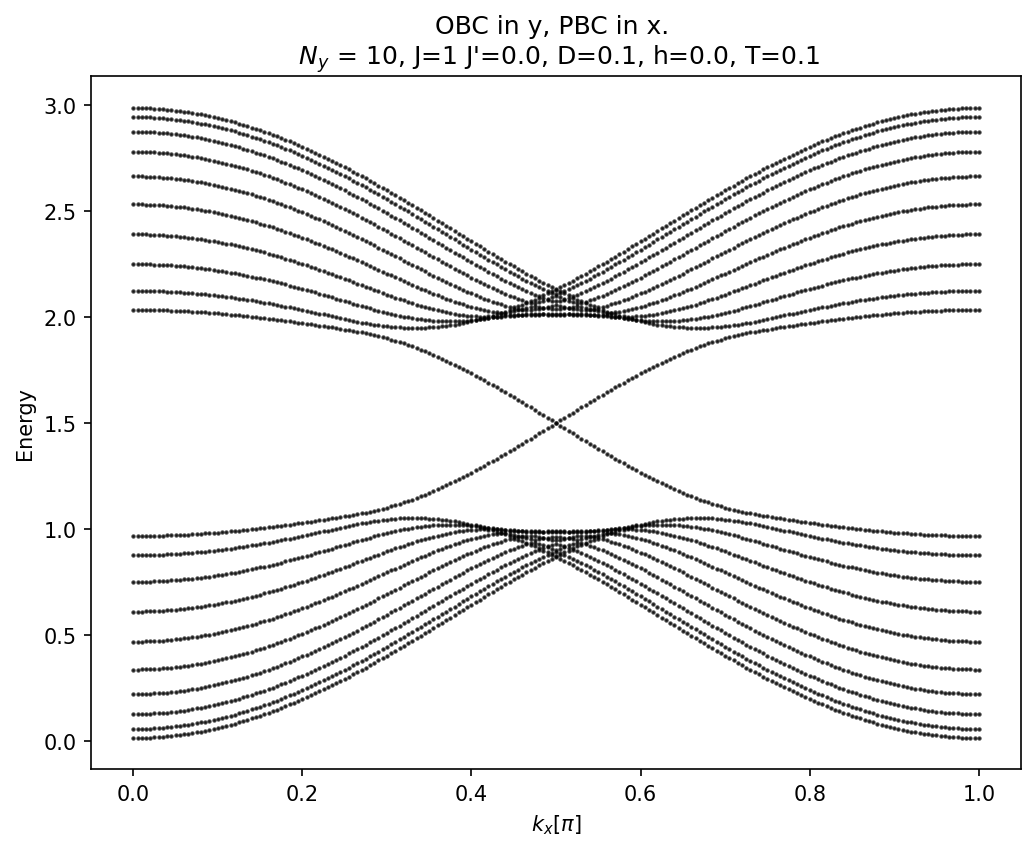

In [24]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

for i in range(len(E)):
    # j = i/N
    c = ['r', 'g', 'b', 'c']
    marks = ['o', 'D', 's']
    # colormap viridis
    # ax.scatter(bands[i, :], Er[:,i], color=plt.cm.hsv(j), s=10, alpha=0.8, marker=f'{marks[i%3]}')
    ax.scatter(bands[i, :], Er[:,i], 
        # color=f'{c[i%4]}', s=5, alpha=0.7, marker=f'{marks[i%3]}')
        color='k', s=5, alpha=0.7, marker='.')
    
ax.set_xlabel('$k_x [\\pi]$')
ax.set_ylabel('Energy')
# ax.set_xlim(0, 1)
# ax.set_xlim(0.5, 1.5)
# ax.set_ylim(-0.7, 0.7)
title = f"OBC in y, PBC in x. \n $N_y$ = {ny}, J={j} J'={J}, D={D}, h={h}, T={T}"
ax.set_title(title)

# plt.savefig(f'./louvre/cylinder_m{m}_J{j}_Jp{J}_D{D}_h{h}_T{T}_{bc[0]}{bc[1]}.png', dpi=100)

plt.show()

## 2nd order

In [ ]:
j = 1
J = 0.
D = 0.
h = 0.0
T = 0.2

iter = 20

K = np.pi/a1
spec = np.array([0, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 0.8, 1.0])*K
# spec = np.linspace(0, K, 11)
# spec = np.linspace(0.4*K, 0.6*K, 11)
E_1 = []
E_2 = []
# bc = ['A', 'B'] # boundary condition
for k in spec:
    Ea = 0
    Eb = 0
    Ea, _, _ = eigenv(hamiltonian_0(j, J, D, h, k))
    E_1.append(np.real(Ea))
    Eb = hamiltonian_mft(iter, T, j, J, D, h, k)
    E_2.append(np.real(Eb))
    
E1 = np.array(E_1)
E2 = np.array(E_2)
bands = np.array([spec] * len(Ea))/K

Iteration 0 finished.
Iteration 1 finished.
Iteration 2 finished.
Iteration 3 finished.
Iteration 4 finished.
Iteration 5 finished.
Iteration 6 finished.
Iteration 7 finished.
Iteration 8 finished.
Iteration 9 finished.
Iteration 10 finished.
Iteration 11 finished.
Iteration 12 finished.
Iteration 13 finished.
Iteration 14 finished.
Iteration 15 finished.
Iteration 16 finished.
Iteration 17 finished.
Iteration 18 finished.
Iteration 19 finished.
Iteration 0 finished.
Iteration 1 finished.
Iteration 2 finished.
Iteration 3 finished.
Iteration 4 finished.
Iteration 5 finished.
Iteration 6 finished.
Iteration 7 finished.
Iteration 8 finished.
Iteration 9 finished.
Iteration 10 finished.
Iteration 11 finished.
Iteration 12 finished.
Iteration 13 finished.
Iteration 14 finished.
Iteration 15 finished.
Iteration 16 finished.
Iteration 17 finished.
Iteration 18 finished.
Iteration 19 finished.
Iteration 0 finished.
Iteration 1 finished.
Iteration 2 finished.
Iteration 3 finished.
Iteration 4 

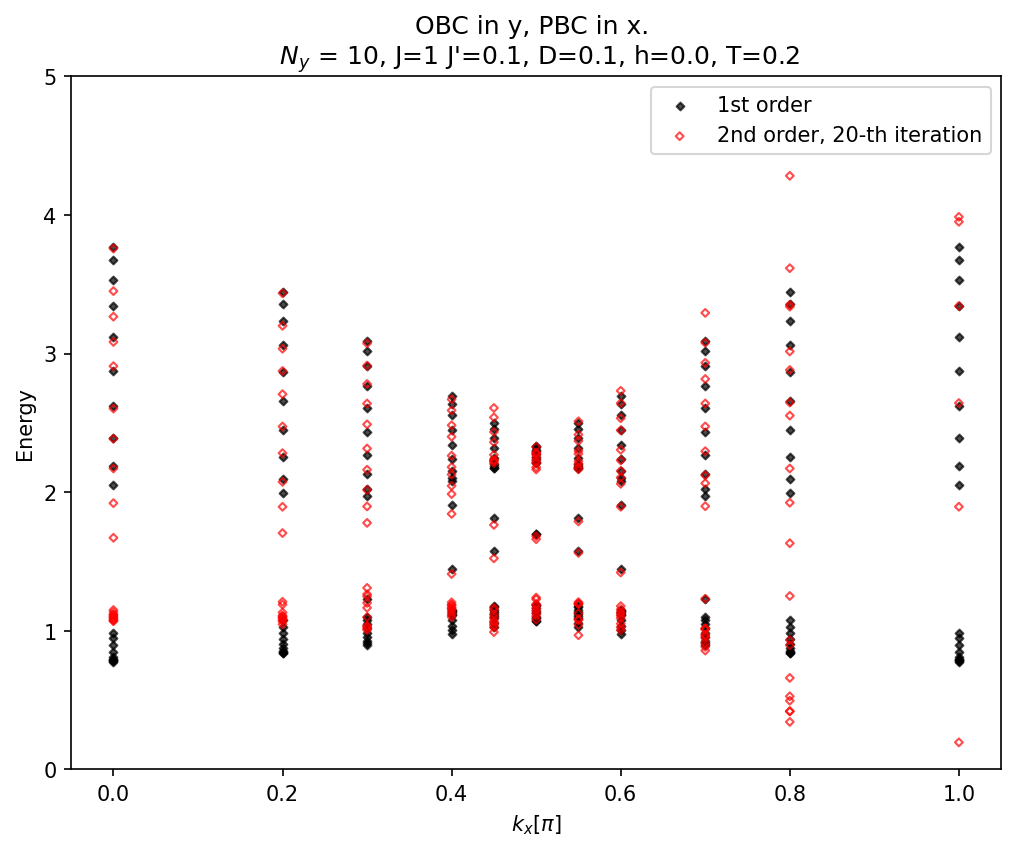

In [82]:
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

for i in range(len(Ea)-1):
    ax.scatter(bands[i, :], E1[:,i], 
        color='k', s=7, alpha=0.7, marker='D')
    ax.scatter(bands[i, :], E2[:,i], 
        edgecolors='r', facecolors='none', s=7, alpha=0.7, marker='D', zorder=10)

ax.scatter(bands[N-1, :], E1[:,N-1], 
    color='k', s=7, alpha=0.7, marker='D', label='1st order', zorder=1)
ax.scatter(bands[N-1, :], E2[:,N-1], 
    edgecolors='r', facecolors='none', s=7, alpha=0.7, marker='D', label=f'2nd order, {iter}-th iteration', zorder=10)
    
ax.set_xlabel('$k_x [\\pi]$')
ax.set_ylabel('Energy')
# ax.set_xlim(0, 1)
# ax.set_xlim(0.5, 1.5)
ax.set_ylim(0, 5)
ax.legend()
title = f"OBC in y, PBC in x. \n $N_y$ = {ny}, J={j} J'={J}, D={D}, h={h}, T={T}"
ax.set_title(title)

plt.savefig(f'./louvre/MagnonMFT_{ny}_J{j}_Jp{J}_D{D}_h{h}_T{T}_itr{iter}.png', dpi=100)

plt.show()

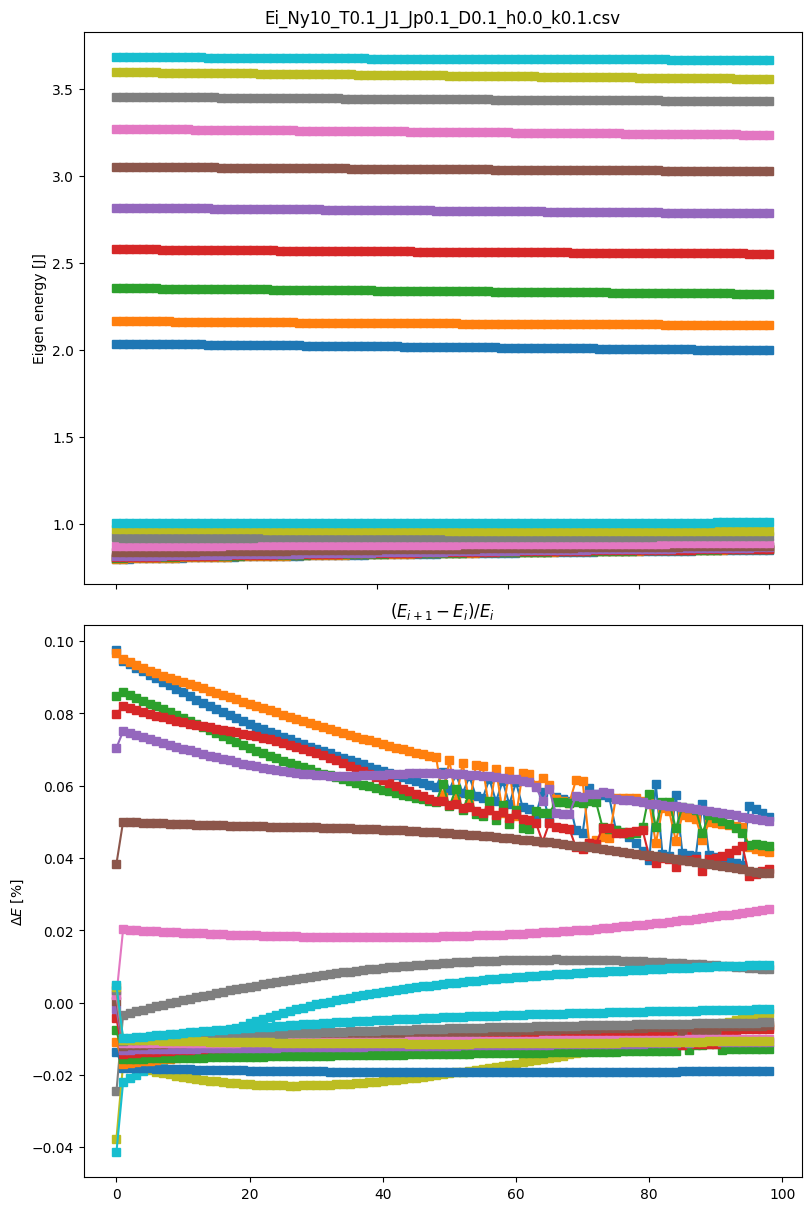

In [44]:
file = f'Ei_Ny{10}_T{0.1}_J{1}_Jp{0.1}_D{0.1}_h{0.0}_k{0.1}.csv'
iterations = 100

fig, axs = plt.subplots(2, 1, figsize=(8, 12), layout='constrained')

data = pd.read_csv(file)

ax = axs[0]
for i in range(len(data.columns)):
    ax.plot(data.iloc[:, i], label=f'E{i}', marker='s')
    
# ax.set_ylim(0.85, 1.18)
ax.set_ylabel('Eigen energy [J]')
ax.label_outer()
ax.set_title(file)

ax = axs[1]
for i in range(len(data.columns)):
    delta = []
    for j in range(iterations-1):
        delta.append(100*(data.iloc[j+1, i]-data.iloc[j, i])/data.iloc[j, i])
    ax.plot(delta, label=f'E{i}', marker='s')

# ax.set_ylim(-200, 200)
ax.set_ylabel('$\Delta E$ [%]')
ax.set_title('$(E_{i+1} - E_i)/E_i$')

plt.savefig(f'./louvre/{file[:-4]}.png', dpi=100)
plt.show()

In [43]:
j = 1
J = 0.1
D = 0.1
h = 0.0
T = 0.11

iter = 100

k = 0.1
K = k*np.pi/a1

file = f'./Ei_Ny{ny}_T{T}_J{j}_Jp{J}_D{D}_h{h}_k{k}.csv'

hamiltonian_mft(iter, T, j, J, D, h, K, txtout=file)

Iteration 0 finished.
Iteration 1 finished.
Iteration 2 finished.
Iteration 3 finished.
Iteration 4 finished.
Iteration 5 finished.
Iteration 6 finished.
Iteration 7 finished.
Iteration 8 finished.
Iteration 9 finished.
Iteration 10 finished.
Iteration 11 finished.
Iteration 12 finished.
Iteration 13 finished.
Iteration 14 finished.
Iteration 15 finished.
Iteration 16 finished.
Iteration 17 finished.
Iteration 18 finished.
Iteration 19 finished.
Iteration 20 finished.
Iteration 21 finished.
Iteration 22 finished.
Iteration 23 finished.
Iteration 24 finished.
Iteration 25 finished.
Iteration 26 finished.
Iteration 27 finished.
Iteration 28 finished.
Iteration 29 finished.
Iteration 30 finished.
Iteration 31 finished.
Iteration 32 finished.
Iteration 33 finished.
Iteration 34 finished.
Iteration 35 finished.
Iteration 36 finished.
Iteration 37 finished.
Iteration 38 finished.
Iteration 39 finished.
Iteration 40 finished.
Iteration 41 finished.
Iteration 42 finished.
Iteration 43 finished

array([3.663456  -1.1870560e-17j, 3.5191984 -1.7897611e-17j,
       3.4104354 -1.5240280e-17j, 3.2006335 -1.7537645e-17j,
       3.008767  -1.3723883e-17j, 2.751122  -1.5838510e-17j,
       2.5350394 -1.1486486e-17j, 2.2890263 -1.1014944e-17j,
       2.1278727 -4.3372227e-18j, 1.9543667 -5.3553828e-18j,
       1.0228205 -2.6850250e-17j, 0.9621992 -1.4818671e-17j,
       0.9388424 -8.5033224e-18j, 0.9228368 +6.4499061e-18j,
       0.90490997-4.4023806e-17j, 0.8811037 -8.1619798e-19j,
       0.8965671 -2.5161307e-17j, 0.88591987+1.4931666e-18j,
       0.89171785-1.5005989e-18j, 0.8891367 +1.5918796e-17j],
      dtype=complex64)